# [IAPR 2020:][iapr2020] Lab 1 ‒  Image segmentation

**Author:** Chun-Hung Yeh, Kuan Tung, Zhuoyue Wang

**Due date:** 26.03.2020

[iapr2018]: https://github.com/LTS5/iapr-2020

## Extract relevant data
We first need to extract the `lab-01-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [1]:
import tarfile
import os
import cv2
import scipy.ndimage
from skimage import measure
from skimage.color import rgb2gray
from skimage.segmentation import active_contour

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-01-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

## Part 1: Brain segmentation

Your goal: compute the size of the brain (in pixels) in a 2D image of a human head taken by Magnetic Resonance Imaging (MRI).
* Try as many methods as you can, the more the better.
* At least region growing and contour detection.

### 1.1 Brain image visualization

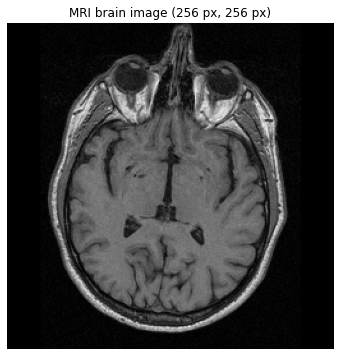

In [2]:
import numpy as np
import skimage.io
import matplotlib.pyplot as plt
%matplotlib inline

# Load image
data_path = os.path.join(data_base_path, data_folder)
brain_im = skimage.io.imread(os.path.join(data_path, 'brain-slice40.tiff'))
im_h, im_w = brain_im.shape

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(brain_im, cmap='gray')
ax.set_title('MRI brain image ({} px, {} px)'.format(im_h, im_w))
ax.axis('off')
plt.show()

### 1.2 Region growing
Add your implementation and discussion

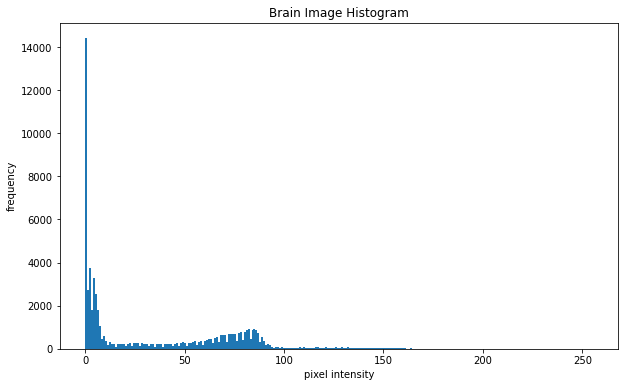

In [3]:
# check the pixel histogram of the image
plt.figure(figsize = (10, 6))
plt.hist(brain_im.ravel(), bins = 256, range = (0, 255))
plt.xlabel('pixel intensity')
plt.ylabel('frequency')
plt.title('Brain Image Histogram')
plt.show()

**Explanation**
- From the above plot, the image histogram is bimodal, which can be divided into two groups. One is for background, and the other is for the brain.
- Most pixels in one group have low values around 0, reflecting that they belong to the background.
- Thus, the pixels with the intensity around 50 to 100 now belong to the brain.

#### ***Region-growing Algorithm Explained***
Region growing is a pixel-based segmentation method which involves the selection of initial seed points. The approach examines neighboring points of initial seed points and determines if the pixel neighbors should be added. The key problem is thresholding, choosing the best threshold value to minimize the probability of wrong classification. By trials and errors, we could find out a suitable threshold for separating the distribution of these groups. 

In [4]:
# region growing function
def region_grow(img, threshold, start_point):
    def grow(x_start, y_start, image, threshold, pixels, img_mask):
        pixel = []
        im_w, im_h = image.shape
        pixel_new = [[x_start+i, y_start+j] for i in range(-1, 2) for j in range(-1, 2)  if x_start+i in range(im_w) and y_start+j in range(im_h) if i != j]
        for t in pixel_new:
            x, y = t
            if np.abs(int(image[x, y])-int(image[x_start, y_start])) < threshold and t not in pixels:
                if t not in pixel:
                    pixel.append(t)
                    img_mask[t[0], t[1]] = image[t[0], t[1]]
        return pixel, img_mask
    
    im_w, im_h = img.shape
    pixel = [[i, j] for i in range(im_w) for j in range(im_h)]
    pixel_same = [start_point]
    size = 1
    pixels = []
    img_mask = np.zeros(img.shape)
    img_mask[start_point[0],start_point[1]] = img[start_point[0],start_point[1]]
    while(len(pixel_same) > 0):
        pixel_iter = []
        for i in pixel_same:
            x_start, y_start = i
            a, img_mask = grow(x_start, y_start, img, threshold, pixels, img_mask)
            pixels = pixels + a
            pixel_iter += a
        pixel_same = pixel_iter
    return img_mask

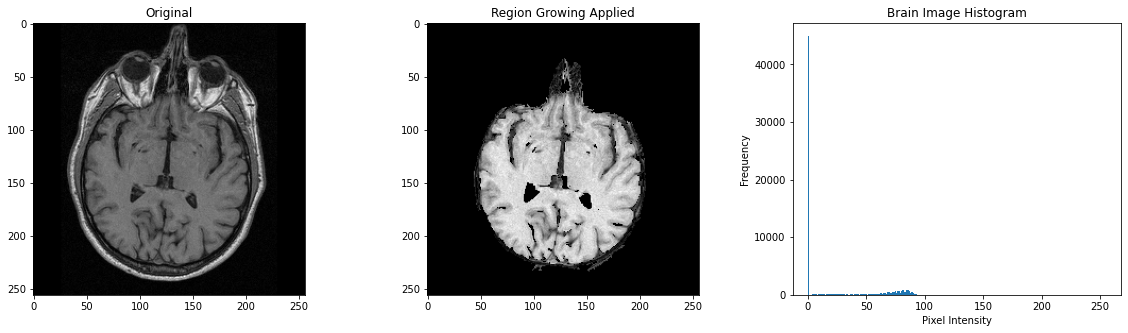


Brain size: 18171 pixels


In [5]:
# apply region-growing method with threshold equal to 10 (<-- trial and error)
brain_image = region_grow(brain_im, 10, [128,128])

# visualize
fig, ax = plt.subplots(1, 3, figsize = (20,5))
ax[0].imshow(brain_im, 'gray')
ax[0].set_title('Original')
ax[1].imshow(brain_image, 'gray')
ax[1].set_title('Region Growing Applied')
ax[2].hist(brain_image.ravel(), bins = 256, range = (0, 255))
ax[2].set_title('Brain Image Histogram')
ax[2].set_xlabel('Pixel Intensity')
ax[2].set_ylabel('Frequency')
plt.show()

# denoise with threshold == 30
brain_image[brain_image < 30] = 0

# compute the size
pixels = sum(sum(brain_image >= 30))
print('\nBrain size: ' + str(pixels) + ' pixels')

**Explanation**
- We select the pixel at (128, 128) as the initial seed point.
- Since the brain histogram follows the heavily right-skewed distribution, we assume that the threshold would be located around 0. Following several trials, we find out the optimal threshold is 10.
- Thus, using region growing we get the brain size equal to 18171 pixels (use this as our benchmark).

# 1.3 Contour detection
Add your implementation and discussion

#### **Inverse method + thresholding**
This method basically applies the inverse of the image to find the brain edges. Specifically, we iterate through the pixels with nonzero values to set the outside of the brain to a high value. As a result, the edges of the brain can be found. Lastly, according to the histogram, we pick a threshold for computation of the brain size.

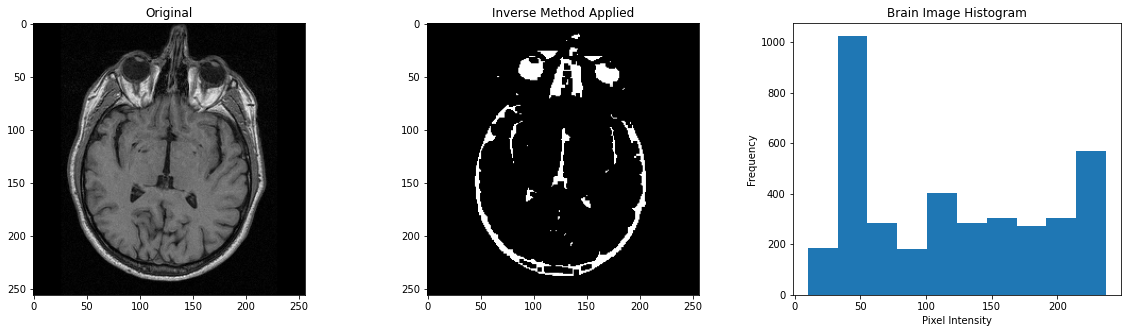

In [6]:
brain_new_image = np.copy(brain_im)

# reduce noise
brain_new_image[brain_new_image < 30] = 0 

# set the outside of the brain to 255
for i in range(len(brain_new_image[:, 1])):
    if len(brain_new_image[i, :].nonzero()[0]) > 0:
        brain_new_image[i, :][np.max(brain_new_image[i,:].nonzero()): 255] = 80
        brain_new_image[i, :][0: np.min(brain_new_image[i,:].nonzero())] = 80
    else:
        brain_new_image[i,:] = 80

brain_new_image[brain_new_image > 30] = 80
brain_new = np.invert(brain_new_image)
brain_new = scipy.ndimage.grey_closing(brain_new,size = (3, 3))
brain_new = scipy.ndimage.grey_erosion(brain_new,size = (2, 2))
brain_new[brain_new < 200] = 0

# visualize brain and its histogram
fig, ax = plt.subplots(1, 3, figsize = (20,5))
ax[0].imshow(brain_im, 'gray')
ax[0].set_title('Original')
ax[1].imshow(brain_new, 'gray')
ax[1].set_title('Inverse Method Applied')
ax[2].hist(list(brain_new.nonzero()[0]))
ax[2].set_title('Brain Image Histogram')
ax[2].set_xlabel('Pixel Intensity')
ax[2].set_ylabel('Frequency')
plt.show()

From the histogram, we can see the pixel discrete at around 90.

In [7]:
# compute the size
pixels, a = 0, 0
for i in range(90, 255):
    if len(brain_new[i,:].nonzero()[0]) > 0:
        a = np.max(brain_new[i,:].nonzero())-np.min(brain_new[i,:].nonzero())
        pixels += a
print('Brain size: ' + str(pixels) + ' pixels')

Brain size: 19672 pixels


**Explanation**
- The histogram is bimodal as well.
- Based on the histogram, we choose the threshold to be around 90. And this could be the optimal threshold to best extract the brain from the rest in the image.
- Finally, the brain size is 19672 pixels, which is a little bit larger than the one using region growing. We speculate that the contour has a width and we include the pixels inside the curvatures, so that's why it's bigger. 

### 1.4 Additional method(s)
Add your implementation and discussion

#### **Method 1: Robert Operator**
Robert operator is used to detect edges by applying a horizontal and verticle filter in a sequence. Both filters are applied to the image and summed to form the final result. The two filters are basic convolution filters of the form: 
$$h_{1} = \begin{bmatrix} 1 & 0 \\ 0 & -1\end{bmatrix},\; h_{2} = \begin{bmatrix} 0 & 1 \\ -1 & 0\end{bmatrix}$$

Robert operator is fast because the filters are small but they are subject to interference by noise. If edges are not very sharp the filters will tend not to detect the edge. 

In [8]:
# Robert Operator
def robert(img):
    h, w = img.shape
    
    # define filters
    horizontal = np.array([[1, 0], [0, -1]]) # h1
    vertical = np.array([[0, 1], [-1, 0]]) # h2 

    # define images with 0s
    newhorizontalImage = np.zeros((h, w))
    newverticalImage = np.zeros((h, w))
    newgradientImage = np.zeros((h, w))

    # offset by 1
    for i in range(1, h - 1):
        for j in range(1, w - 1):
            horizontalGrad = (horizontal[0, 0] * img[i - 1, j - 1]) + \
                             (horizontal[0, 1] * img[i - 1, j]) + \
                             (horizontal[1, 0] * img[i, j - 1]) + \
                             (horizontal[1, 1] * img[i, j])

            newhorizontalImage[i - 1, j - 1] = abs(horizontalGrad)

            verticalGrad = (vertical[0, 0] * img[i - 1, j - 1]) + \
                           (vertical[0, 1] * img[i - 1, j]) + \
                           (vertical[1, 0] * img[i, j - 1]) + \
                           (vertical[1, 1] * img[i, j])

            newverticalImage[i - 1, j - 1] = abs(verticalGrad)

            # Edge Magnitude
            mag = np.sqrt(pow(horizontalGrad, 2.0) + pow(verticalGrad, 2.0))
            newgradientImage[i - 1, j - 1] = mag
            newgradientImage = scipy.ndimage.grey_closing(newgradientImage, size = (3, 3))
            newgradientImage[newgradientImage < 75] = 0

    fig, ax = plt.subplots(1, 3, figsize = (20,5))
    ax[0].imshow(brain_im, 'gray')
    ax[0].set_title('Original')
    ax[1].imshow(newgradientImage, cmap='gray')
    ax[1].set_title('Robert Operator Applied')
    ax[2].hist(newgradientImage.nonzero()[0])
    ax[2].set_title('Brain Image Histogram')
    ax[2].set_xlabel('Pixel Intensity')
    ax[2].set_ylabel('Frequency')
    plt.show()
    
    # compute the size
    pixels, a = 0, 0
    for i in range(115, 255):
        if len(newgradientImage[i,:].nonzero()[0]) > 0:
            a = np.max(newgradientImage[i, :].nonzero())-np.min(newgradientImage[i, :].nonzero())
            pixels += a
    print('\nBrain size: ' + str(pixels) + ' pixels')

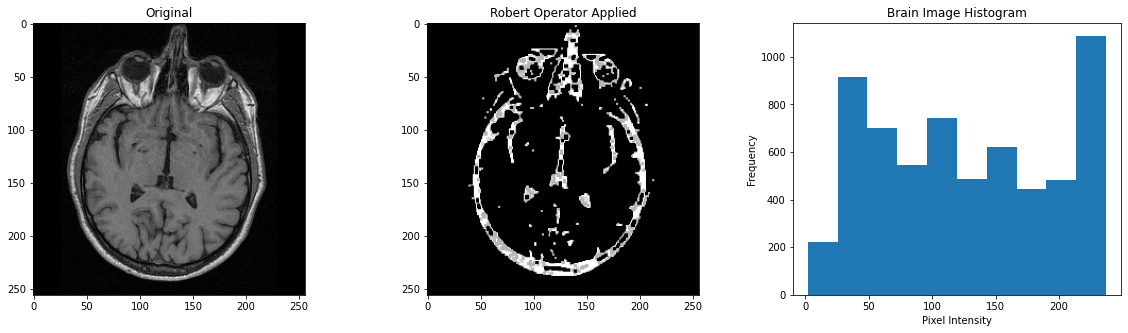


Brain size: 16842 pixels


In [9]:
# apply the Robert operator for contour detection
robert(brain_new_image)

#### **Explanation**
- The histogram approximately follows the bimodal distribution.
- By trials and errors, we select the threshold at 115.
- It turns out the predicted brain size is smaller than the previous two methods.

#### **Method 2: Sobel Operator**
Sobel operator is the most commonly used operator for edge detection. Similar to Robert operator, it is based on convolving the image with a small, separable, and integer-valued filters in horizontal and vertical direction and is therefore relatively inexpensive in terms of computations. Its filter form: 

$$h_{1} = \begin{bmatrix} 1 & 2 & 1\\ 0 & 0 & 0\\ -1 & -2 & -1\end{bmatrix},\; h_{2} = \begin{bmatrix}-1 & 0 & 1\\ -2 & 0 & 2\\ -1 & 0 & 1\end{bmatrix}$$

However, Sobel operator also provides differentiating (which gives the edge response) and smoothing (which reduces noise) concurrently.

In [10]:
# Sobel Operator
def sobel(img):
    h, w = img.shape
    
    # define filters
    horizontal = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]]) # h1
    vertical = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])  # h2

    # define images with 0s
    newhorizontalImage = np.zeros((h, w))
    newverticalImage = np.zeros((h, w))
    newgradientImage = np.zeros((h, w))

    # offset by 1
    for i in range(1, h - 1):
        for j in range(1, w - 1):
            horizontalGrad = (horizontal[0, 0] * img[i - 1, j - 1]) + \
                             (horizontal[0, 1] * img[i - 1, j]) + \
                             (horizontal[0, 2] * img[i - 1, j + 1]) + \
                             (horizontal[1, 0] * img[i, j - 1]) + \
                             (horizontal[1, 1] * img[i, j]) + \
                             (horizontal[1, 2] * img[i, j + 1]) + \
                             (horizontal[2, 0] * img[i + 1, j - 1]) + \
                             (horizontal[2, 1] * img[i + 1, j]) + \
                             (horizontal[2, 2] * img[i + 1, j + 1])

            newhorizontalImage[i - 1, j - 1] = abs(horizontalGrad)

            verticalGrad = (vertical[0, 0] * img[i - 1, j - 1]) + \
                           (vertical[0, 1] * img[i - 1, j]) + \
                           (vertical[0, 2] * img[i - 1, j + 1]) + \
                           (vertical[1, 0] * img[i, j - 1]) + \
                           (vertical[1, 1] * img[i, j]) + \
                           (vertical[1, 2] * img[i, j + 1]) + \
                           (vertical[2, 0] * img[i + 1, j - 1]) + \
                           (vertical[2, 1] * img[i + 1, j]) + \
                           (vertical[2, 2] * img[i + 1, j + 1])

            newverticalImage[i - 1, j - 1] = abs(verticalGrad)

            # Edge Magnitude
            mag = np.sqrt(pow(horizontalGrad, 2.0) + pow(verticalGrad, 2.0))
            newgradientImage[i - 1, j - 1] = mag
            newgradientImage = scipy.ndimage.grey_closing(newgradientImage, size = (3, 3))
            newgradientImage[newgradientImage < 75] = 0

    fig, ax = plt.subplots(1, 3, figsize = (20,5))
    ax[0].imshow(brain_im, 'gray')
    ax[0].set_title('Original')
    ax[1].imshow(newgradientImage, cmap='gray')
    ax[1].set_title('Sobel Operator Applied')
    ax[2].hist(newgradientImage.nonzero()[0])
    ax[2].set_title('Brain Image Histogram')
    ax[2].set_xlabel('Pixel Intensity')
    ax[2].set_ylabel('Frequency')
    plt.show()
    
    # compute the size
    pixels, a = 0, 0
    for i in range(141, 255):
        if len(newgradientImage[i,:].nonzero()[0]) > 0:
            a = np.max(newgradientImage[i, :].nonzero())-np.min(newgradientImage[i, :].nonzero())
            pixels += a
    print('\nBrain size: ' + str(pixels) + ' pixels')

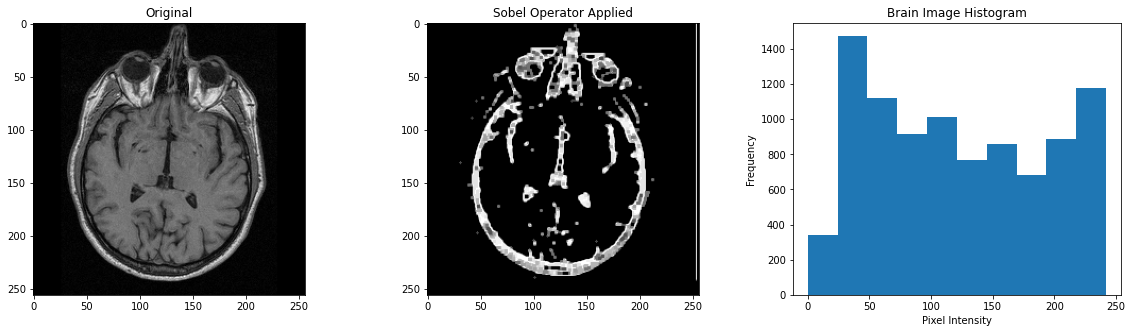


Brain size: 19432 pixels


In [11]:
sobel(brain_new_image)

#### **Explanation**
- The image histogram is bimodal roughly.
- Since this is not a sharply skewed bimodal distribution, the threshold could be in the range [100, 200]. Here we pick the value at 141.
- The brain size is slightly larger than the benchmark, which could result from that we include the contours.

#### **Method 3: Prewitt Operator**
Prewitt operator is similar to Sobel operator and is used for detecting vertical and horizontal edges in images. Yet, unlike the Sobel, this operator does not place any emphasis on the pixels that are closer to the center of the mask. Its form is:

$$h_{1} = \begin{bmatrix} 0 & 1 & 1\\ -1 & 0 & 1\\ -1 & -1 & 0\end{bmatrix},\; h_{2} = \begin{bmatrix}-1 & 0 & 1\\ -1 & 0 & 1\\ -1 & 0 & 1\end{bmatrix}$$

In [14]:
# Prewitt Operator
def prewitt(img): 
    h, w = img.shape
    
    # define filters
    horizontal = np.array([[0, 1, 1], [-1, 0, 1], [-1, -1, 0]]) # h1
    vertical = np.array([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]]) # h2

    # define images with 0s
    newgradientImage = np.zeros((h, w))

    # offset by 1
    for i in range(1, h - 1):
        for j in range(1, w - 1):
            horizontalGrad = (horizontal[0, 0] * img[i - 1, j - 1]) + \
                             (horizontal[0, 1] * img[i - 1, j]) + \
                             (horizontal[0, 2] * img[i - 1, j + 1]) + \
                             (horizontal[1, 0] * img[i, j - 1]) + \
                             (horizontal[1, 1] * img[i, j]) + \
                             (horizontal[1, 2] * img[i, j + 1]) + \
                             (horizontal[2, 0] * img[i + 1, j - 1]) + \
                             (horizontal[2, 1] * img[i + 1, j]) + \
                             (horizontal[2, 2] * img[i + 1, j + 1])

            verticalGrad = (vertical[0, 0] * img[i - 1, j - 1]) + \
                           (vertical[0, 1] * img[i - 1, j]) + \
                           (vertical[0, 2] * img[i - 1, j + 1]) + \
                           (vertical[1, 0] * img[i, j - 1]) + \
                           (vertical[1, 1] * img[i, j]) + \
                           (vertical[1, 2] * img[i, j + 1]) + \
                           (vertical[2, 0] * img[i + 1, j - 1]) + \
                           (vertical[2, 1] * img[i + 1, j]) + \
                           (vertical[2, 2] * img[i + 1, j + 1])

            # Edge Magnitude
            mag = np.sqrt(pow(horizontalGrad, 2.0) + pow(verticalGrad, 2.0))
            newgradientImage[i - 1, j - 1] = mag
            newgradientImage[newgradientImage < 75] = 0
            
    fig, ax = plt.subplots(1, 3, figsize = (20, 8))
    ax[0].imshow(brain_im, 'gray')
    ax[0].set_title('Original')
    ax[1].imshow(newgradientImage.astype('uint8'), cmap='gray')
    ax[1].set_title('Prewitt Operator Applied')
    ax[2].hist(newgradientImage.nonzero()[0])
    ax[2].set_title('Brain Image Histogram')
    ax[2].set_xlabel('Pixel Intensity')
    ax[2].set_ylabel('Frequency')
    plt.show()

    # compute the size
    pixels, a = 0, 0
    for i in range(140, 255):
        if len(newgradientImage[i,:].nonzero()[0]) > 0:
            a = np.max(newgradientImage[i, :].nonzero())-np.min(newgradientImage[i, :].nonzero())
            pixels += a
    print('\nBrain size: ' + str(pixels) + ' pixels')

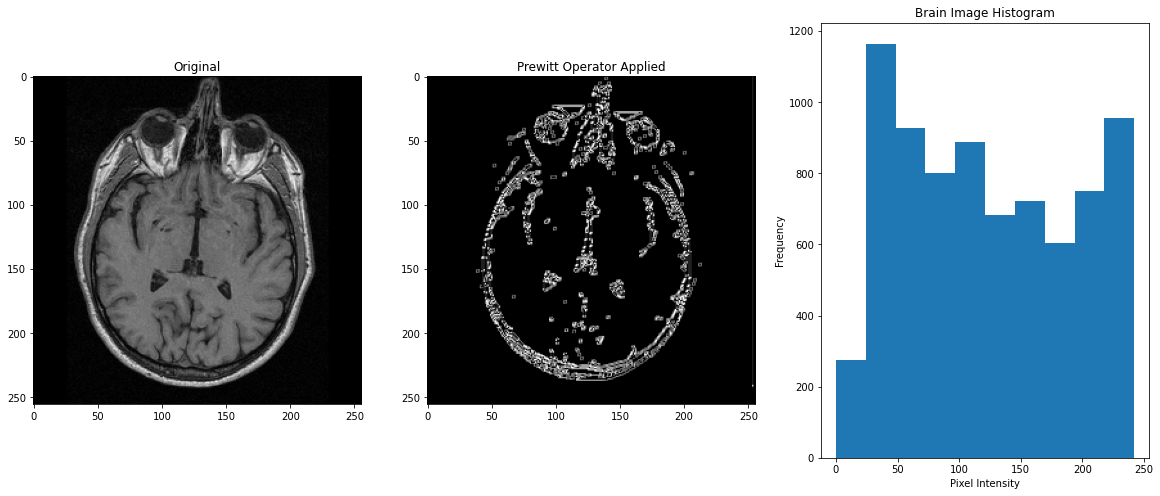


Brain size: 19159 pixels


In [15]:
prewitt(brain_new_image)

#### **Explanation**
- Similar reason as the previous method, the histogram again is bimodal (not very apparent though).
- Here we pick the threshold at 140 so that the brain size prediction is 19159 pixels.

#### **Method 4: Laplacian**
Unlike the Sobel and Prewitt’s edge detectors, Laplacian operator calculates second order derivatives in a single pass. Two commonly used small kernels are: 

$$h_{1} = \begin{bmatrix} 0 & -1 & 0\\ -1 & 4 & -1\\ 0 & -1 & 0\end{bmatrix},\; h_{2} = \begin{bmatrix}-1 & -1 & -1\\ -1 & 8 & 1\\ -1 & -1 & -1\end{bmatrix}$$

Because these masks are approximating a second derivative measurement on the image, they are very sensitive to noise. To correct this, the image is often Gaussian smoothed before applying the Laplacian filter.

In [14]:
# Laplacian Operator
def laplacian(img): 
    h, w = img.shape
    
    # define filters
    horizontal = np.array([[0, -1, 0], [-1, 4, -1], [0, -1, 0]]) # h1
    vertical = np.array([[-1, -1, -1], [-1, 8, 1], [-1, -1, -1]]) # h2

    # define images with 0s
    newgradientImage = np.zeros((h, w))

    # offset by 1
    for i in range(1, h - 1):
        for j in range(1, w - 1):
            horizontalGrad = (horizontal[0, 0] * img[i - 1, j - 1]) + \
                             (horizontal[0, 1] * img[i - 1, j]) + \
                             (horizontal[0, 2] * img[i - 1, j + 1]) + \
                             (horizontal[1, 0] * img[i, j - 1]) + \
                             (horizontal[1, 1] * img[i, j]) + \
                             (horizontal[1, 2] * img[i, j + 1]) + \
                             (horizontal[2, 0] * img[i + 1, j - 1]) + \
                             (horizontal[2, 1] * img[i + 1, j]) + \
                             (horizontal[2, 2] * img[i + 1, j + 1])

            verticalGrad = (vertical[0, 0] * img[i - 1, j - 1]) + \
                           (vertical[0, 1] * img[i - 1, j]) + \
                           (vertical[0, 2] * img[i - 1, j + 1]) + \
                           (vertical[1, 0] * img[i, j - 1]) + \
                           (vertical[1, 1] * img[i, j]) + \
                           (vertical[1, 2] * img[i, j + 1]) + \
                           (vertical[2, 0] * img[i + 1, j - 1]) + \
                           (vertical[2, 1] * img[i + 1, j]) + \
                           (vertical[2, 2] * img[i + 1, j + 1])

            # Edge Magnitude
            mag = np.sqrt(pow(horizontalGrad, 2.0) + pow(verticalGrad, 2.0))
            newgradientImage[i - 1, j - 1] = mag
            newgradientImage = scipy.ndimage.grey_closing(newgradientImage.astype('uint8'), size = (3, 3))
            newgradientImage[newgradientImage < 220] = 0
            
    fig, ax = plt.subplots(1, 3, figsize = (20,5))
    ax[0].imshow(brain_im, 'gray')
    ax[0].set_title('Original')
    ax[1].imshow(newgradientImage, cmap='gray')
    ax[1].set_title('Laplacian Operator Applied')
    ax[2].hist(newgradientImage.nonzero()[0])
    ax[2].set_title('Brain Image Histogram')
    ax[2].set_xlabel('Pixel Intensity')
    ax[2].set_ylabel('Frequency')
    plt.show()

    # compute the size
    pixels, a = 0, 0
    for i in range(150, 255):
        if len(newgradientImage[i,:].nonzero()[0]) > 0:
            a = np.max(newgradientImage[i, :].nonzero())-np.min(newgradientImage[i, :].nonzero())
            pixels += a
    print('\nBrain size: ' + str(pixels) + ' pixels')

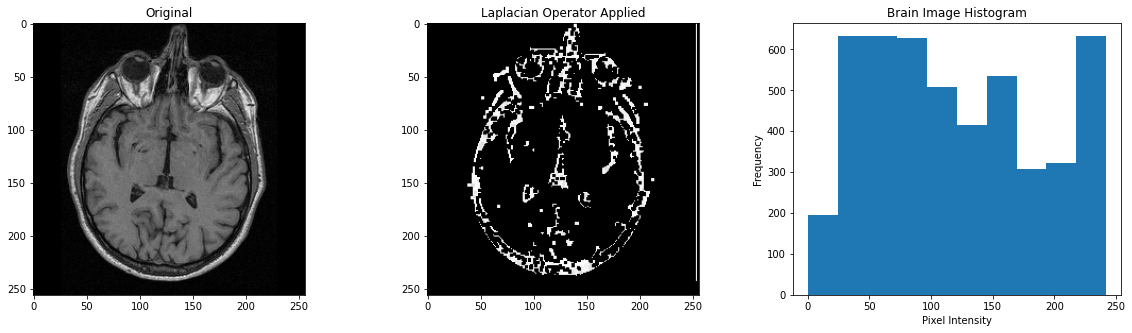


Brain size: 16820 pixels


In [15]:
laplacian(brain_new_image)

**Explanation**
- As shown above, we set the threshold at 150, and the prediction of the size is slightly smaller than the benchmark. 
- We guess it's because the contour using the operator also contain some part of the brain, decreasing the predicted brain size. 

#### **Method 5: Canny Operator**
Canny operator is an edge detection operator using a multi-stage algorithm to detect a wide range of edges in images. Specifically, it does the following: 

1. Smooth the image with a Gaussian filter to reduce noise.
2. Compute gradient of using any of the gradient operators Sobel or Prewitt.
3. Extract edge points: Non-maximum suppression.
4. Linking and thresholding: Hysteresis.

Note that in the third step, we are trying to relate the edge direction to a direction that can be traced along the edges based on the previously calculated gradient strengths and edge directions. At each pixel location we have four possible directions. We check all directions if the gradient is maximum at this point. Perpendicular pixel values are compared with the value in the edge direction. If their value is lower than the pixel on the edge then they are suppressed. After this step we will get broken thin edges that needs to be fixed. Finally, in the fourth step, we iterate over the pixels and check if the current pixel is an edge. If it’s an edge then check surrounding area for edges. If they have the same direction then we mark them as an edge pixel. We also use 2 thresholds, a high and low. If the pixels is greater than lower threshold it is marked as an edge. Then pixels that are greater than the lower threshold and also are greater than high threshold, are also selected as strong edge pixels. When there are no more changes to the image we stop.

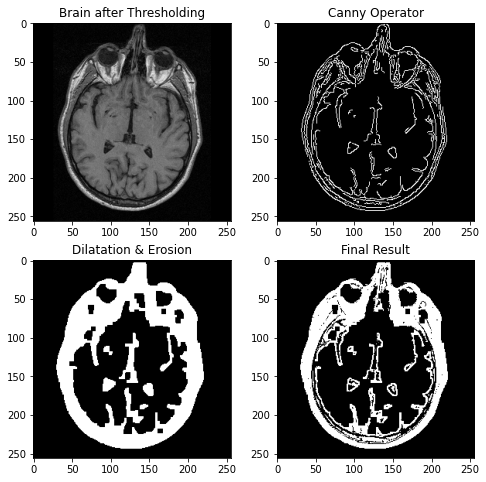

In [16]:
# Apply Canny Operator
# from the histogram of the brain image, the second cluster has threshold at 60 to 90.
brain_new_image_1 = brain_im.copy()
edges = cv2.Canny(brain_new_image_1, 100, 200, 3, L2gradient = True)
brain_di = scipy.ndimage.binary_dilation(edges, structure = np.ones((8,8))).astype('uint8')
brain_di = scipy.ndimage.binary_erosion(brain_di, structure = np.ones((6,6))).astype('uint8')
brain_new_image_2 = brain_new_image.copy()
brain_new_image_2[brain_di==0] = 0

# visualize
plt.figure(figsize = (8, 8))
plt.subplot(2, 2, 1)
plt.imshow(brain_new_image_1, cmap = 'gray')
plt.title('Brain after Thresholding')
plt.subplot(2, 2, 2)
plt.imshow(edges, cmap = 'gray')
plt.title('Canny Operator')
plt.subplot(2, 2, 3)
plt.imshow(brain_di, cmap = 'gray')
plt.title('Dilatation & Erosion')
plt.subplot(2, 2, 4)
plt.imshow(brain_new_image_2, cmap='gray')
plt.title('Final Result')
plt.show()

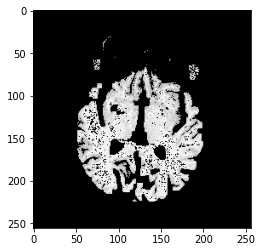


Brain size: 12787 pixels


In [18]:
# extract the brain from the image
temp = brain_im - 2*brain_new_image_2
temp[temp < 100] = 0
temp = np.abs(brain_im - temp)
temp[temp >= 90] = 0
temp[temp <= 60] = 0

plt.imshow(temp, cmap = 'gray')
plt.show()
print('\nBrain size: ' + str(np.sum(temp!=0)) + ' pixels')

**Explanation**
- From the final result, we actually get the well-shaped contour.
- However, our manual denoising method makes us lose some pixels about the brain; thus, the estimated brain size is much smaller than the benchmark.

#### **Method 6: Active Contour, Snake**
The active contour model is a method to fit open or closed splines to lines or edges in an image. It works by minimising an energy that is in part defined by the image and part by the spline’s shape: length and smoothness. The minimization is done implicitly in the shape energy and explicitly in the image energy. Here we first implement the snake operator function to detect the shape of the brain and then use it to estimate the size of the brain.

In [19]:
# Snake Operator
def snake(img, r,gau,g,alpha,beta,w_edge,gamma):
    s = np.linspace(0, 2*np.pi, 400)
    x = 125 + r*np.cos(s)
    y = 150 + r*np.sin(s)
    init = np.array([x, y]).T
    
    if gau:snake = active_contour(gaussian(img,g),init, alpha, beta,w_edge, gamma)
    else:  snake = active_contour(img,init, alpha, beta,w_edge, gamma)

    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(img, cmap=plt.cm.gray)
    ax.plot(init[:, 0], init[:, 1], '--r',  lw=3)
    ax.plot(snake[:, 0], snake[:, 1], '-b', lw=3)
    ax.set_xticks([]), ax.set_yticks([])
    ax.axis([0, img.shape[1], img.shape[0], 0])
    return snake

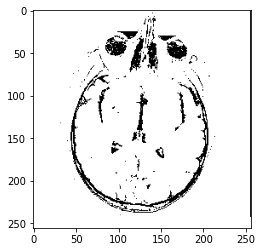

In [20]:
plt.imshow(brain_new_image, 'gray')
plt.show()

/Users/chunhungyeh/opt/anaconda3/envs/iapr2020/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: The coordinates used by `active_contour` will change from xy coordinates (transposed from image dimensions) to rc coordinates in scikit-image 0.18. Set `coordinates='rc'` to silence this warning. `coordinates='xy'` will restore the old behavior until 0.18, but will stop working thereafter.
  if __name__ == '__main__':


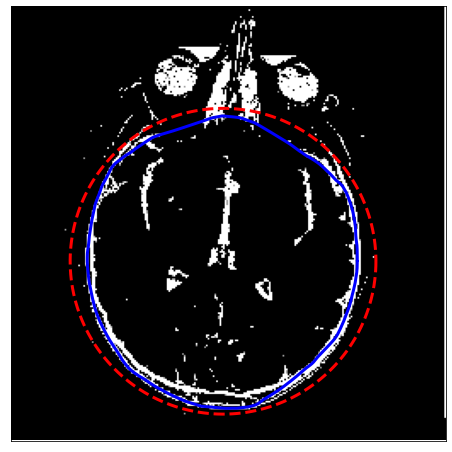

In [21]:
snake_img = snake(np.invert(brain_new_image), r = 90, gau = False, g = 0.1, alpha = 0.2, beta = 0.01, w_edge = 0.1, gamma = 0.01)

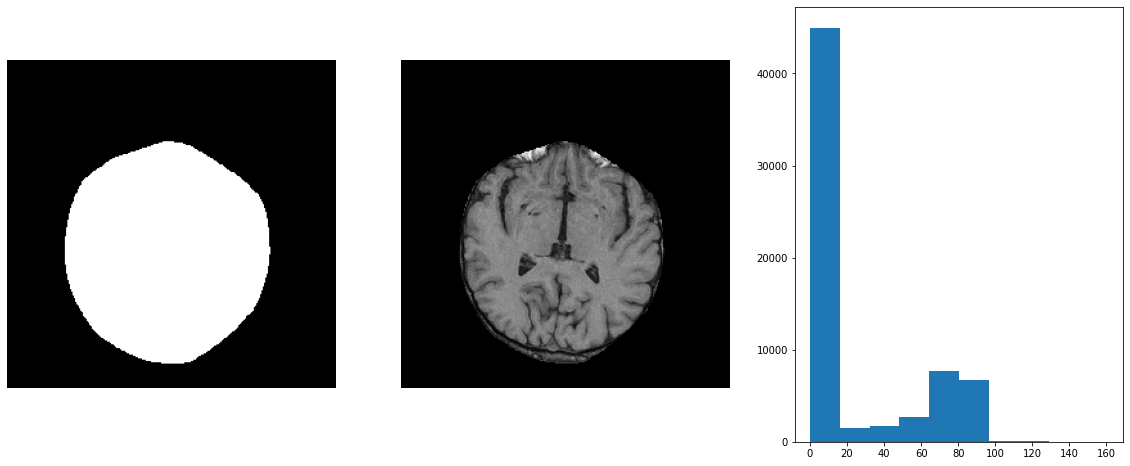


Brain size: 19164 pixels


In [22]:
# extract the area in the contour
snake_img_int = snake_img.astype(int)
mask = cv2.drawContours(np.zeros(brain_im.shape), [snake_img_int], 0, 1, -1)
brain_area = brain_im * mask

# visualize
fig, ax = plt.subplots(1, 3, figsize=(20, 8))
ax[0].imshow(mask, cmap=plt.cm.gray)
ax[0].axis('off')
ax[1].imshow(brain_area, cmap=plt.cm.gray)
ax[1].axis('off')
ax[2].hist(brain_area.ravel())
plt.show()

# compute the size of the brain
# from the histogram, we choose 30 as threshold to calculate the number of pixels
threshold = 30;
size = sum(sum(brain_area > 30))
print('\nBrain size: ' + str(size) + ' pixels')

**Explanation**
- The size is a little bigger than we calculate in the former part. It's because the snake contour does not catch the specific contour of the brain. Instead, it only catches the edge of the simple geometic shape of the brain.

## Part 2: Shape/color segmentation

You will find hereafter three pictures taken under three different illuminations, containing some shapes with different colors. We ask you to create a routine to:

1. Count the number of shapes of each color.
2. Compute the total area (in pixels) of each color.

Please note that one specific challenge is to be robust to illumination changes. Therefore some kind of intensity normalization should probably be used.

**Note:** the routine(s) that you will write for this exercise will be useful for the final project as well, so pay special attention to it.

### 2.1 Visualization

In [14]:
# Load images
im_names = ['arena-shapes-01', 'arena-shapes-02', 'arena-shapes-03']
filenames = [os.path.join(data_path, name) + '.png' for name in im_names]
ic = skimage.io.imread_collection(filenames)
images = skimage.io.concatenate_images(ic)
print('Number of images: ', images.shape[0])
print('Image size: {}, {} '.format(images.shape[1], images.shape[2]))
print('Number of color channels: ', images.shape[-1])

Number of images:  3
Image size: 480, 640 
Number of color channels:  3


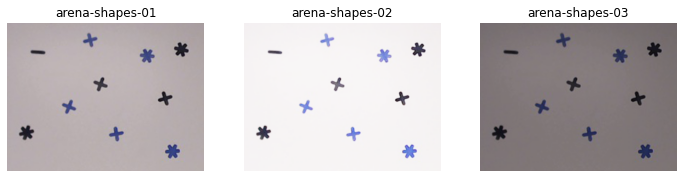

In [15]:
# Plot images
fig, axes = plt.subplots(1, 3, figsize=(12, 12))
for ax, im, nm in zip(axes.ravel(), images, im_names):
    ax.imshow(im)
    ax.axis('off')
    ax.set_title(nm)
plt.show()

### 2.2 Number of shapes of each color
Add your implementation and discussion

In [16]:
# transform image to hsv color space and detect the given color
def hsv_detection(image, lower_color, upper_color):  
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    mask1 = cv2.inRange(hsv, lower_color, upper_color)
    res = cv2.bitwise_and(image, image, mask = mask1)
    return res

# color range
def color_seg(choice):
    if choice == 'blue':
        lower_hue = np.array([0,0,30])
        upper_hue = np.array([25,230,255])
    elif choice == 'white':
        lower_hue = np.array([0,0,0])
        upper_hue = np.array([0,0,255])
    elif choice == 'black':
        lower_hue = np.array([0,0,0])
        upper_hue = np.array([255, 90, 200])
    return lower_hue, upper_hue

# increase the brightness of an image
def increase_brightness(img, value=30):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)
    lim = 255 - value
    v[v > lim] = 255
    v[v <= lim] += value
    final_hsv = cv2.merge((h, s, v))
    img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)
    return img

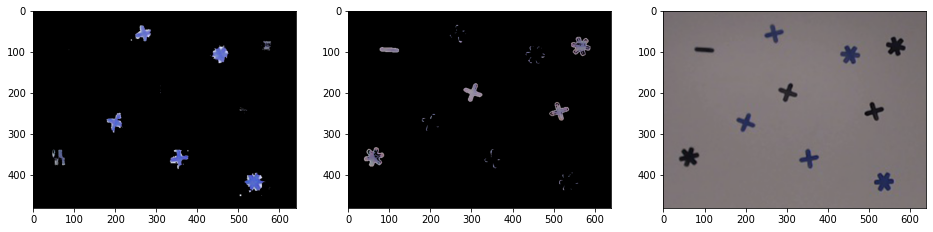

In [17]:
# increase the bright degree
image_new = increase_brightness(images[2], value = 120)

# find different colors
lower_blue, upper_blue = color_seg('blue')
lower_black, upper_black = color_seg('black')

blue = hsv_detection(image_new, lower_blue, upper_blue)
black = hsv_detection(image_new, lower_black, upper_black)

# threshold the hsv image to get the given colors
fig, ax = plt.subplots(1, 3, figsize = (16, 16))
ax[0].imshow(np.abs(blue))
ax[1].imshow(np.abs(black))
ax[2].imshow(images[2])
plt.show()

In [18]:
np.unique(blue[blue.nonzero()])

array([ 52,  53,  54,  55,  56,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182,
       183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195,
       196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208,
       209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,
       222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 23

In [19]:
blue.shape

(480, 640, 3)

In [20]:
np.unique(black[black.nonzero()])

array([ 86,  88,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100,
       101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113,
       114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126,
       127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139,
       140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152,
       153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165,
       166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178,
       179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191,
       192, 193, 194, 195, 196, 197, 198, 199, 200], dtype=uint8)

In [78]:
# suppress the noise by removing all components smaller than a user-defined threshold


# find the center of each item
def location(img, component_size):
    img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img_gray[img_gray > 150] = 255
    labels, num = measure.label(img_gray,neighbors = 8, return_num = True)
    labels_new = noise_rm(labels, component_size)
    a, num = measure.label(labels_new,neighbors = 8, return_num = True)
    centerpoint = []
    for i in range(num):
        c = a==i+1
        label = int(len(c.nonzero()[1])/2) # take the center point
        centerpoint.append([c.nonzero()[0][label],c.nonzero()[1][label]])
    return centerpoint

# after removing the noise we grow the region from the center
def repairpicture(img,color,threshold,component_size):
    try: #process the rgb picture
        img_gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
        center = location(color,component_size)
        x,y = img_gray.shape
        imgj = np.zeros((x,y))
        for j in center:
            imgj += region(img_gray,threshold,j)
        a,b = imgj.nonzero()
        img_out = np.zeros((x,y,3),dtype=np.uint8)
        img_out[a,b,:] = img[a,b,:]
    except: # if gray picture use this part
        img_gray  = img
        center = location(color,component_size)
        x,y = img_gray.shape
        imgj = np.zeros((x,y))
        for j in center:
            imgj += region(img_gray,threshold,j)
        a,b = imgj.nonzero()
        img_out = np.zeros((x,y),dtype=np.uint8)
        img_out[a,b] = img[a,b]
    return img_out

# detect how many shapes in each color
def detectshapeofColor(image, contrast, threshold, color):
    # create a CLAHE object
    # use Contrast Limited Adaptive Histogram Equalization to adjust the contrast
    p, m = 0, 0
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    clahe = cv2.createCLAHE(clipLimit = contrast, tileGridSize = (1, 1))
    cl1 = clahe.apply(gray)
    color = repairpicture(cl1, color, 6, 120)
    gray = ndimage.grey_closing(color, size = (3, 3))
    img, contours, h = cv2.findContours(gray, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    # caculate the number of edges of the contour
    # use the number of edges to determine the shape
    for cnt in contours:
        approx = cv2.approxPolyDP(cnt, 0.025*cv2.arcLength(cnt, True), True)
        if len(approx)==3: t=t+1 # triangle
        elif len(approx) ==4:s=s+1 # square
        elif len(approx) > 7:c=c+1 # circle
    print ("{} triangle".format(t)+"|"+"{} square".format(s)+"|"+"{} circle".format(c))
    return color

def shapes_of_each_color():
    Plot_images(images, im_names)

    colors = ['blue', 'black']
    color_names = ['blue', 'black']
    
    color_areas=[]
    for i, image in enumerate(images):
        print('===============================================================================')
        print('For the arena-shapes-0{}'.format(i+1))
        for index,color in enumerate (colors):
            print('{}:'.format(color_names[index]))
            image_tmp = detectshapeofColor(image,5,6,color)
            color_areas.append(image_tmp)
    #return the images list after repairation
    return  color_areas

### 2.3 Total area (in pixels) of each color
Add your implementation and discussion